##**📌 Section 1: Project Overview (Markdown Cell)**
Explain:

Problem statement (Dynamic pricing for parking)

Objective (Maximize utilization using ML-based pricing)

Tools used: Python, Pandas, NumPy, Pathway, Bokeh

##**📌 Section 2: Data Loading + EDA**
Load dataset.csv

Explore columns: Occupancy, Capacity, QueueLength, etc.

Combine Date + Time into Timestamp

Plot any trends if you want (optional)

##**📌 Section 3: Model 1 — Linear Occupancy-Based Pricing**
Include:

Explanation of formula

Price
𝑡
+
1
=
Price
𝑡
+
𝛼
⋅
(
Occupancy
Capacity
)
Price
t+1
​
 =Price
t
​
 +α⋅(
Capacity
Occupancy
​
 )
Code

Static visualization using matplotlib (optional)

##**📌 Section 4: Model 2 — Demand-Based Pricing**
Include:

Features used: Occupancy, Queue, Traffic, Special Day, Vehicle Type

Demand formula

Normalized pricing function

Integration into Pathway via pricing_logic()

##**📌 Section 5: Model 3 — Competitive Pricing**
Include:

Use of Haversine formula

Nearby competitor logic

Adjust price based on nearby price average

Optional: rerouting logic added to output

##**📌 Section 6: Real-Time Visualization (Bokeh + Panel)**
Include:

price_plotter() function

delta_window.plot(...) binding

pn.Column(viz).servable()

Screenshot or instructions to serve if needed

In [1]:
import pandas as pd
import numpy as np

In [2]:
df = pd.read_csv("dataset.csv")

In [3]:
print("🔹 First 5 rows of the dataset:")
df.head()

🔹 First 5 rows of the dataset:


,ID,SystemCodeNumber,Capacity,Latitude,Longitude,Occupancy,VehicleType,TrafficConditionNearby,QueueLength,IsSpecialDay,LastUpdatedDate,LastUpdatedTime
0,0,BHMBCCMKT01,577,26.144536,91.736172,61,car,low,1,0,04-10-2016,07:59:00
1,1,BHMBCCMKT01,577,26.144536,91.736172,64,car,low,1,0,04-10-2016,08:25:00
2,2,BHMBCCMKT01,577,26.144536,91.736172,80,car,low,2,0,04-10-2016,08:59:00
3,3,BHMBCCMKT01,577,26.144536,91.736172,107,car,low,2,0,04-10-2016,09:32:00
4,4,BHMBCCMKT01,577,26.144536,91.736172,150,bike,low,2,0,04-10-2016,09:59:00


In [4]:
print("\n🔹 Dataset Info:")
df.info()


🔹 Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18368 entries, 0 to 18367
Data columns (total 12 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   ID                      18368 non-null  int64  
 1   SystemCodeNumber        18368 non-null  object 
 2   Capacity                18368 non-null  int64  
 3   Latitude                18368 non-null  float64
 4   Longitude               18368 non-null  float64
 5   Occupancy               18368 non-null  int64  
 6   VehicleType             18368 non-null  object 
 7   TrafficConditionNearby  18368 non-null  object 
 8   QueueLength             18368 non-null  int64  
 9   IsSpecialDay            18368 non-null  int64  
 10  LastUpdatedDate         18368 non-null  object 
 11  LastUpdatedTime         18368 non-null  object 
dtypes: float64(2), int64(5), object(5)
memory usage: 1.7+ MB


In [5]:
print("\n🔹 Summary Statistics (Numerical):")
df.describe()


🔹 Summary Statistics (Numerical):


,ID,Capacity,Latitude,Longitude,Occupancy,QueueLength,IsSpecialDay
count,18368.000000,18368.000000,18368.000000,18368.000000,18368.000000,18368.000000,18368.000000
mean,9183.500000,1605.214286,25.706547,90.751170,731.084059,4.587925,0.150915
std,5302.529208,1131.153886,1.582749,3.536636,621.164982,2.580062,0.357975
min,0.000000,387.000000,20.000035,78.000003,2.000000,0.000000,0.000000
25%,4591.750000,577.000000,26.140048,91.727995,322.000000,2.000000,0.000000
50%,9183.500000,1261.000000,26.147482,91.729511,568.000000,4.000000,0.000000
75%,13775.250000,2803.000000,26.147541,91.736172,976.000000,6.000000,0.000000
max,18367.000000,3883.000000,26.150504,91.740994,3499.000000,15.000000,1.000000


In [6]:
print("\n🔹 Missing Values:")
df.isnull().sum()


🔹 Missing Values:


,0
ID,0
SystemCodeNumber,0
Capacity,0
Latitude,0
Longitude,0
Occupancy,0
VehicleType,0
TrafficConditionNearby,0
QueueLength,0
IsSpecialDay,0


In [8]:
print("\n🔹 Unique Vehicle Types:")
print(df['VehicleType'].unique())

print("\n🔹 Unique Special Days:")
print(df['IsSpecialDay'].unique())


🔹 Unique Vehicle Types:
['car' 'bike' 'truck' 'cycle']

🔹 Unique Special Days:
[0 1]


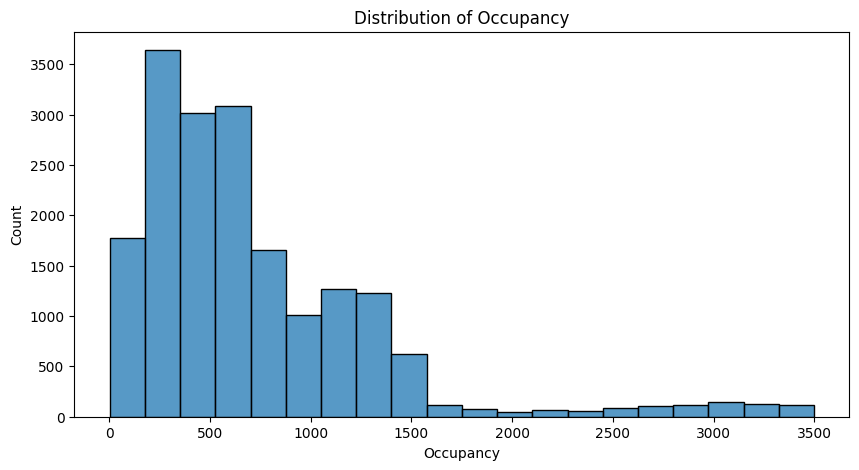

In [16]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(10,5))
sns.histplot(df['Occupancy'], bins=20)
plt.title("Distribution of Occupancy")
plt.xlabel("Occupancy")
plt.ylabel("Count")
plt.show()

In [11]:
# Combine date and time columns into one datetime column (day comes first in your data)
df['Timestamp'] = pd.to_datetime(
    df['LastUpdatedDate'] + ' ' + df['LastUpdatedTime'],
    dayfirst=True  # Important!
)

# Sort by timestamp
df = df.sort_values(by='Timestamp')

##**Model 1 – Baseline Linear Model**

In [12]:
BASE_PRICE = 10.0
ALPHA = 0.5
MIN_PRICE = 5.0
MAX_PRICE = 20.0

In [13]:
def calculate_price(prev_price, occupancy, capacity):
    """
    Calculate new price based on occupancy.
    """
    # Safety check: avoid division by zero
    if capacity == 0:
        return prev_price

    # Calculate price update
    delta = ALPHA * (occupancy / capacity)
    new_price = prev_price + delta

    # Clip price within bounds
    new_price = max(MIN_PRICE, min(MAX_PRICE, new_price))

    return round(new_price, 2)

In [14]:
# Filter for one parking lot (e.g., 'BHMBCCMKT01')
lot_df = df[df['SystemCodeNumber'] == 'BHMBCCMKT01'].copy()

# Sort by time
lot_df = lot_df.sort_values(by='Timestamp')

# Create price column
prices = []
prev_price = BASE_PRICE

for i, row in lot_df.iterrows():
    occupancy = row['Occupancy']
    capacity = row['Capacity']

    new_price = calculate_price(prev_price, occupancy, capacity)
    prices.append(new_price)

    prev_price = new_price  # update for next step

lot_df['Price'] = prices

# Show final output
lot_df[['Timestamp', 'Occupancy', 'Capacity', 'Price']].head(10)

,Timestamp,Occupancy,Capacity,Price
0,2016-10-04 07:59:00,61,577,10.05
1,2016-10-04 08:25:00,64,577,10.11
2,2016-10-04 08:59:00,80,577,10.18
3,2016-10-04 09:32:00,107,577,10.27
4,2016-10-04 09:59:00,150,577,10.40
5,2016-10-04 10:26:00,177,577,10.55
6,2016-10-04 10:59:00,219,577,10.74
7,2016-10-04 11:25:00,247,577,10.95
8,2016-10-04 11:59:00,259,577,11.17
9,2016-10-04 12:29:00,266,577,11.40


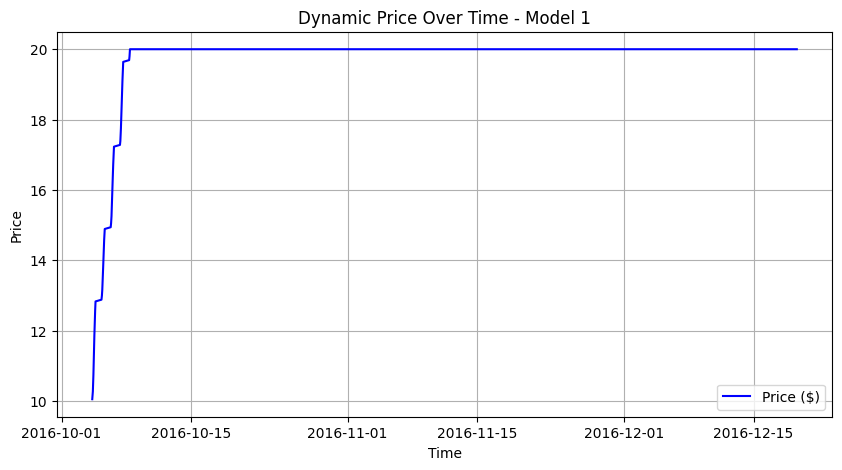

In [15]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 5))
plt.plot(lot_df['Timestamp'], lot_df['Price'], label='Price ($)', color='blue')
plt.title("Dynamic Price Over Time - Model 1")
plt.xlabel("Time")
plt.ylabel("Price")
plt.grid(True)
plt.legend()
plt.show()

## **Model 2 – Demand-Based Pricing**

In [20]:
# Weights (you can tune these later)
ALPHA = 0.6     # occupancy weight
BETA = 0.3      # queue length weight
GAMMA = 0.4     # traffic weight
DELTA = 0.8     # special day weight
EPSILON = 0.5   # vehicle type weight
LAMBDA = 0.5    # price sensitivity

In [21]:
# Traffic level mapping
traffic_map = {'low': 1, 'medium': 2, 'high': 3}

# Vehicle type weight
vehicle_weight_map = {'bike': 0.3, 'car': 1.0, 'truck': 1.5}

In [22]:
def demand_based_price(row):
    # Extract features
    occupancy = row['Occupancy']
    capacity = row['Capacity']
    queue = row['QueueLength']
    traffic = traffic_map.get(row['TrafficConditionNearby'].lower(), 2)
    special_day = row['IsSpecialDay']
    vehicle_type = vehicle_weight_map.get(row['VehicleType'].lower(), 1.0)

    # Step 1: Compute Demand
    demand = (
        ALPHA * (occupancy / capacity) +
        BETA * queue -
        GAMMA * traffic +
        DELTA * special_day +
        EPSILON * vehicle_type
    )

    # Step 2: Normalize Demand (e.g., between 0 and 1)
    normalized_demand = (demand - 0) / (10 - 0)  # assuming demand maxes at ~10
    normalized_demand = max(0, min(1, normalized_demand))  # clip

    # Step 3: Price from Base
    price = BASE_PRICE * (1 + LAMBDA * normalized_demand)
    price = max(MIN_PRICE, min(MAX_PRICE, price))  # clip

    return round(price, 2)

In [23]:
df['Model2_Price'] = df.apply(demand_based_price, axis=1)
df[['Occupancy', 'QueueLength', 'TrafficConditionNearby', 'VehicleType', 'Model2_Price']].head(10)

,Occupancy,QueueLength,TrafficConditionNearby,VehicleType,Model2_Price
0,61,1,low,car,10.23
5248,237,2,low,bike,10.23
3936,264,2,low,car,10.47
6560,249,2,low,car,10.50
17056,614,2,low,cycle,10.45
2624,117,2,low,car,10.42
7872,178,2,low,car,10.43
14432,445,3,average,bike,10.23
9184,709,2,low,car,10.46
10496,195,1,low,car,10.22


In [24]:
def pricing_logic(record):
    return demand_based_price(record)

##**Model 3: Competitive Pricing Model**

In [26]:
import math

def haversine(lat1, lon1, lat2, lon2):
    R = 6371  # Earth radius in KM
    phi1 = math.radians(lat1)
    phi2 = math.radians(lat2)
    delta_phi = math.radians(lat2 - lat1)
    delta_lambda = math.radians(lon2 - lon1)

    a = math.sin(delta_phi/2)**2 + math.cos(phi1) * math.cos(phi2) * math.sin(delta_lambda/2)**2
    c = 2 * math.atan2(math.sqrt(a), math.sqrt(1 - a))

    return R * c

In [27]:
def build_competitor_map(df):
    competitors = {}

    for i, row1 in df[['SystemCodeNumber', 'Latitude', 'Longitude']].drop_duplicates().iterrows():
        lot_id = row1['SystemCodeNumber']
        lat1, lon1 = row1['Latitude'], row1['Longitude']
        nearby = []

        for j, row2 in df[['SystemCodeNumber', 'Latitude', 'Longitude']].drop_duplicates().iterrows():
            if lot_id == row2['SystemCodeNumber']:
                continue
            lat2, lon2 = row2['Latitude'], row2['Longitude']
            dist = haversine(lat1, lon1, lat2, lon2)

            if dist <= 1.0:  # within 1km
                nearby.append(row2['SystemCodeNumber'])

        competitors[lot_id] = nearby

    return competitors

competitor_map = build_competitor_map(df)

In [28]:
def competitive_price_logic(row, df_snapshot):
    lot_id = row['SystemCodeNumber']
    my_price = demand_based_price(row)
    my_occupancy = row['Occupancy']
    my_capacity = row['Capacity']

    # Find nearby lots
    nearby_lots = competitor_map.get(lot_id, [])

    # Filter for current timestamp
    current_time = row['Timestamp']
    nearby_prices = []

    for lot in nearby_lots:
        match = df_snapshot[
            (df_snapshot['SystemCodeNumber'] == lot) &
            (df_snapshot['Timestamp'] == current_time)
        ]
        if not match.empty:
            nearby_prices.append(match.iloc[0]['Model2_Price'])  # or real-time price

    # If no competitors found, return normal price
    if not nearby_prices:
        return my_price

    avg_nearby_price = sum(nearby_prices) / len(nearby_prices)

    # Logic: adjust based on competition
    if my_occupancy >= my_capacity:
        if my_price > avg_nearby_price:
            return max(MIN_PRICE, my_price - 1.0)  # decrease slightly
        else:
            return my_price  # already cheaper
    elif my_price < avg_nearby_price:
        return min(MAX_PRICE, my_price + 1.0)  # raise price slightly

    return my_price  # default

In [29]:
def pricing_logic(record):
    return competitive_price_logic(record, df)

In [31]:
import math

def haversine(lat1, lon1, lat2, lon2):
    R = 6371
    phi1, phi2 = math.radians(lat1), math.radians(lat2)
    dphi = math.radians(lat2 - lat1)
    dlambda = math.radians(lon2 - lon1)

    a = math.sin(dphi/2)**2 + math.cos(phi1) * math.cos(phi2) * math.sin(dlambda/2)**2
    c = 2 * math.atan2(math.sqrt(a), math.sqrt(1 - a))
    return R * c

In [32]:
def build_competitor_map(df):
    competitors = {}

    lots = df[['SystemCodeNumber', 'Latitude', 'Longitude']].drop_duplicates()

    for _, lot1 in lots.iterrows():
        lot_id = lot1['SystemCodeNumber']
        lat1, lon1 = lot1['Latitude'], lot1['Longitude']
        nearby = []

        for _, lot2 in lots.iterrows():
            if lot_id == lot2['SystemCodeNumber']:
                continue
            lat2, lon2 = lot2['Latitude'], lot2['Longitude']
            dist = haversine(lat1, lon1, lat2, lon2)
            if dist <= 1.0:
                nearby.append(lot2['SystemCodeNumber'])

        competitors[lot_id] = nearby

    return competitors

# Build once
competitor_map = build_competitor_map(df)

In [33]:
def competitive_price_logic(row, df_snapshot):
    lot_id = row['SystemCodeNumber']
    my_price = demand_based_price(row)
    my_occupancy = row['Occupancy']
    my_capacity = row['Capacity']
    current_time = row['Timestamp']

    nearby_lots = competitor_map.get(lot_id, [])
    nearby_prices = []

    for lot in nearby_lots:
        match = df_snapshot[
            (df_snapshot['SystemCodeNumber'] == lot) &
            (df_snapshot['Timestamp'] == current_time)
        ]
        if not match.empty:
            nearby_prices.append(match.iloc[0]['Model2_Price'])

    if not nearby_prices:
        return my_price

    avg_price = sum(nearby_prices) / len(nearby_prices)

    # Competitive adjustment logic
    if my_occupancy >= my_capacity and my_price > avg_price:
        return round(max(MIN_PRICE, my_price - 1.0), 2)
    elif my_price < avg_price:
        return round(min(MAX_PRICE, my_price + 1.0), 2)

    return round(my_price, 2)

In [34]:
def pricing_logic(record):
    return competitive_price_logic(record, df)  # df = historical snapshot

In [35]:
def pricing_logic(record):
    price = competitive_price_logic(record, df)

    if record['Occupancy'] >= record['Capacity']:
        lot_id = record['SystemCodeNumber']
        competitors = competitor_map.get(lot_id, [])
        for comp_id in competitors:
            comp_row = df[
                (df['SystemCodeNumber'] == comp_id) &
                (df['Timestamp'] == record['Timestamp'])
            ]
            if not comp_row.empty and comp_row.iloc[0]['Model2_Price'] < price:
                record['RerouteSuggested'] = True
                break

    record['FinalPrice'] = price
    return record

In [36]:
!pip install bokeh

In [45]:
!pip install panel --quiet

In [37]:
from bokeh.io import output_notebook, show
from bokeh.plotting import figure
from bokeh.models import ColumnDataSource, HoverTool
from bokeh.layouts import column
from bokeh.palettes import Category10
output_notebook()

In [38]:
# Filter one parking lot
lot_id = 'BHMBCCMKT01'
lot_df = df[df['SystemCodeNumber'] == lot_id].sort_values('Timestamp')

source = ColumnDataSource(data={
    'time': lot_df['Timestamp'],
    'price': lot_df['Model2_Price'],  # Or FinalPrice if Model 3
    'occupancy': lot_df['Occupancy']
})

In [39]:
p = figure(title=f"Price Trend for Lot {lot_id}",
           x_axis_type='datetime',
           width=800, height=400)

p.line(x='time', y='price', source=source, line_width=2, color='navy', legend_label="Price ($)")
p.circle(x='time', y='price', source=source, size=5, color='orange')

hover = HoverTool(tooltips=[
    ("Time", "@time{%F %H:%M}"),
    ("Price", "@price"),
    ("Occupancy", "@occupancy")
], formatters={'@time': 'datetime'})

p.add_tools(hover)
p.xaxis.axis_label = "Timestamp"
p.yaxis.axis_label = "Price ($)"
p.legend.location = "top_left"

show(p)

In [40]:
from bokeh.palettes import Category20
p_multi = figure(title="Prices Over Time - Multiple Lots",
                 x_axis_type='datetime', width=900, height=500)

for i, lot in enumerate(df['SystemCodeNumber'].unique()):
    temp = df[df['SystemCodeNumber'] == lot].sort_values('Timestamp')
    source = ColumnDataSource(data={'time': temp['Timestamp'], 'price': temp['Model2_Price']})
    p_multi.line(x='time', y='price', source=source, line_width=2, color=Category20[20][i % 20], legend_label=lot)

p_multi.xaxis.axis_label = "Time"
p_multi.yaxis.axis_label = "Price"
p_multi.legend.location = "top_left"

show(p_multi)

In [41]:
output_notebook()
show(p)

In [42]:
from bokeh.io import output_notebook, push_notebook, show
from bokeh.plotting import figure
from bokeh.models import ColumnDataSource
from time import sleep
import pandas as pd

output_notebook()

In [46]:
import panel as pn
pn.extension()

/tmp/ipython-input-46-3887293949.py:2: UserWarning: Using Panel interactively in Colab notebooks requires the jupyter_bokeh package to be installed. Install it with:

    !pip install jupyter_bokeh

and try again.
  pn.extension()


In [43]:
# Empty source to start with
source = ColumnDataSource(data=dict(time=[], price=[]))

p = figure(title="Live Price Updates (Model 2 or 3)",
           x_axis_type='datetime', width=800, height=400)

line = p.line(x='time', y='price', source=source, line_width=2, color='green')

handle = show(p, notebook_handle=True)